In [130]:
from typing import *
import numpy as np
from skimage import io
from skimage.transform import rescale, resize
import os
import matplotlib.pyplot as plt
from utils.common_functions import *
import cv2
from scipy import ndimage
from pyefd import elliptic_fourier_descriptors, reconstruct_contour, plot_efd, normalize_efd



### Reading images

In [12]:
def read_images():
    dataset_path = '../dataset_sample'

    images = []
    labels = []
    for dirpath, _, filenames in os.walk(dataset_path):
        if not filenames: continue

        for file in filenames:
            if not file.endswith('.jpg') and not file.endswith('.JPG'): 
                print(f'File {file} is not a jpg file. Skipping...')
                continue

            file_path = os.path.join(dirpath, file)

            # to avoid reading corrupted images
            image = cv2.imread(file_path)
            if image is None:
                print(f'File {file} is not a valid image. Skipping...')
                continue
            
            images.append(image)
            labels.append(int(file[0]))
    
    return images, labels

In [13]:
images, labels = read_images()


### Preprocessing

In [14]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    resize_ratio = 0.1

    image = cv2.resize(image, (int(image.shape[1] * resize_ratio), int(image.shape[0] * resize_ratio)))
    show_images([image], ['resized image'])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    show_images([image], ['YCRCB image'])

    lower_bound = np.array([0, 133, 77])
    upper_bound = np.array([255, 173, 127])
    image = cv2.inRange(image, lower_bound, upper_bound)
    show_images([image], ['Binary image'])

    # kernel = np.ones((5, 5), np.uint8)
    # image = cv2.dilate(image, kernel, iterations=5)
    # show_images([image])

    kernel = np.ones((5, 5), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    show_images([image], ['Eroded image'])

    image = ndimage.binary_fill_holes(image).astype(np.int8)
    show_images([image], ['Holes filled image'])

    # image = any2gray(image)
    # image = change_gray_range(image, format=255)
    # image = change_gray_range(rescale(image, 0.1, anti_aliasing=True))
    # image = convert_to_binary(image, threshold=140)
    return image

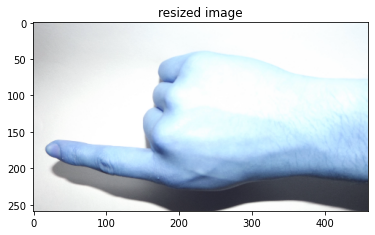

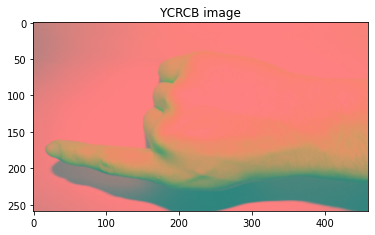

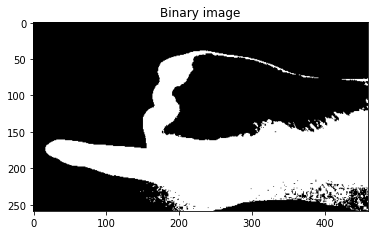

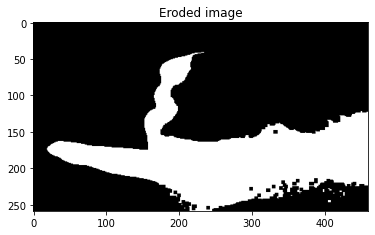

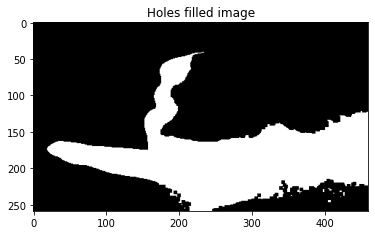

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [15]:
preprocess_image(cv2.imread('../dataset/men/1/1_men (34).JPG'))

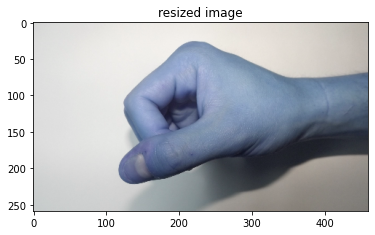

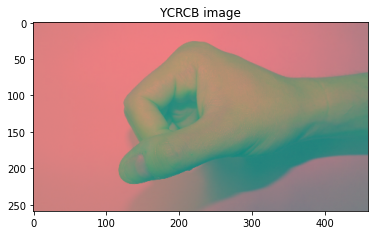

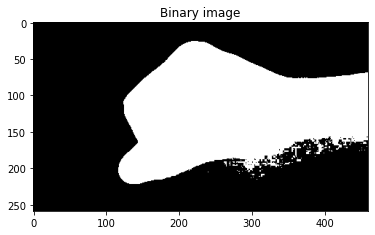

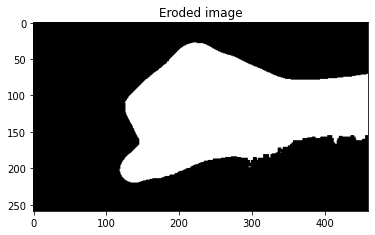

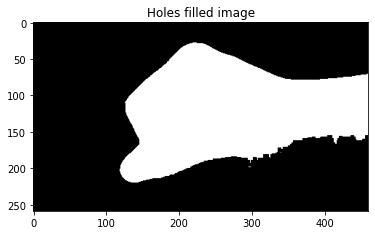

In [16]:
# preprocess all images
for i in range(len(images)):
    images[i] = preprocess_image(images[i].copy())
    break

In [158]:
# should return features
def elliptical_fourier(image: np.ndarray):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    threshold = 255 // 2
    image[image > threshold] = 255
    image[image <= threshold] = 0
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Draw all contours
    contours_image = np.zeros((image.shape[0], image.shape[1], 3))
    cv2.drawContours(contours_image, contours, -1, (0, 255, 255), 1)
    contours_image = contours_image.astype(np.uint8)
    show_images([contours_image], ['contours image'])

    # Draw largest contour
    max_contour = max(contours, key = cv2.contourArea)
    contours_image = np.zeros((image.shape[0], image.shape[1], 3))
    cv2.drawContours(contours_image, max_contour, -1, (0, 255, 255), 1)
    contours_image = contours_image.astype(np.uint8)
    show_images([contours_image], ['Largest contour image'])
    
    # Convert to 2d array
    max_contour = max_contour.reshape(max_contour.shape[0], max_contour.shape[2])
    coefficients = elliptic_fourier_descriptors(max_contour, order=50, normalize=False)

    contour = reconstruct_contour(coefficients)
    contour = contour.reshape(contour.shape[0], 1, contour.shape[1])
    contour = contour.astype(int)

    # min_values = np.min(contour, axis=0)
    # contour = contour - min_values

    contour[:, 0, 0] -= contour[:, 0, 0].min()
    contour[:, 0, 1] += contour[:, 0, 1].max()

    
    contours_image = np.zeros((image.shape[0], image.shape[1], 3))
    cv2.drawContours(contours_image, [contour], -1, (0, 255, 255), 1)
    contours_image = contours_image.astype(np.uint8)
    show_images([contours_image], ['Largest contour image'])

    coefficients = normalize_efd(coefficients)
    return coefficients.flatten()[3:]


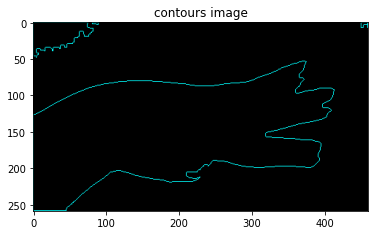

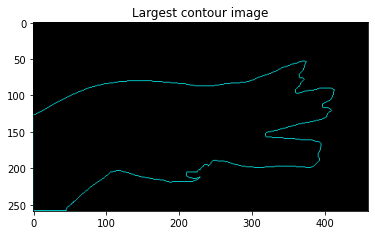

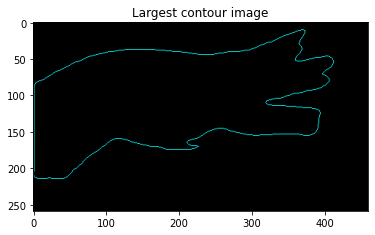

array([-3.79031440e-01, -1.56136844e-01,  8.83556328e-02,  5.89015246e-02,
        4.59632445e-02, -8.06322975e-03,  3.37770044e-05, -5.72722208e-02,
       -6.51866730e-02, -6.62835745e-02,  2.57125731e-02,  4.94904766e-02,
        3.45551003e-02, -8.87719788e-03,  5.35112407e-02, -2.53959260e-02,
        9.16939415e-03,  2.55892294e-02,  4.50537084e-02,  2.08044234e-02,
        4.09524877e-02,  2.71107924e-02,  3.46038565e-02,  6.83766507e-03,
       -2.71849351e-02,  1.00853549e-02,  1.69543484e-02, -1.80687144e-03,
       -5.75085920e-03,  8.76576843e-03,  2.24665499e-02,  7.78607742e-03,
       -3.13442825e-03,  5.32413184e-03, -1.08821082e-02,  5.61002133e-03,
       -1.17038055e-03, -4.56531360e-03, -8.72482696e-03,  3.94282058e-03,
        6.59864404e-03, -6.06484228e-03, -1.37022487e-02, -2.01563139e-03,
        6.99710094e-03,  7.60307311e-03, -4.19372126e-03, -7.26199592e-04,
        9.28489627e-03,  5.76758938e-03, -1.18146692e-02, -8.35130963e-04,
        4.95928271e-03,  

In [159]:
image = cv2.imread('../pp_dataset/3_19.JPG')
elliptical_fourier(image)